In [22]:
import  matplotlib.pyplot as plt
import  numpy as np

from    matplotlib import colors

plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"]  = (25.6,9.6)
plt.rcParams["image.origin"]    = 'lower'

In [26]:
shape = (96, 256)
barrel = np.zeros(shape, dtype=float)

barrel[20,10] = 10
barrel[32,13] = 20

# print(barrel)



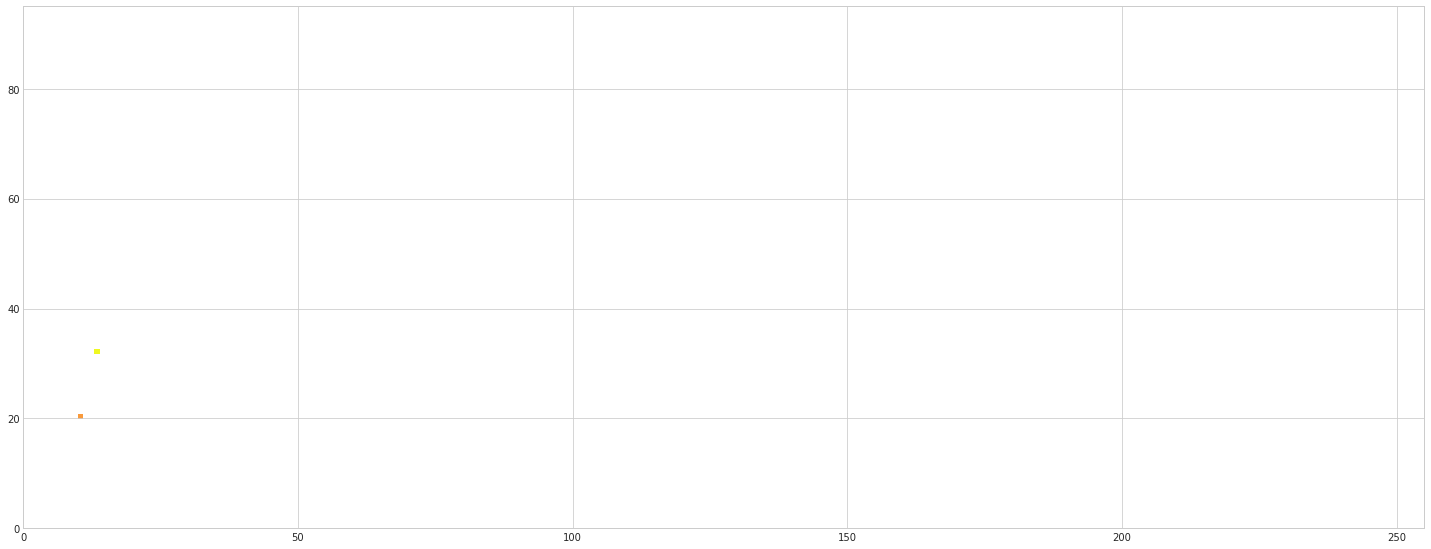

In [27]:
fig, axs = plt.subplots(1)

axs.imshow(barrel, extent=(0.0, 255.0, 0.0, 95.0), norm=colors.LogNorm(1.0), cmap='plasma')